In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilon = 0.0001
alpha = 2
A = 200
B = 10
N = 10
scale = 100
h = 0.01 #step

all_points = [np.asarray([np.random.rand()*scale, np.random.rand()*scale, np.random.rand(), np.random.rand()]) \
                                                                                  for _ in np.arange(N) ]

old_coordinates_of_all_points = coordinates_of_all_points = np.random.rand(N, 2)*scale
old_velocities_of_all_points = velocities_of_all_points = np.random.rand(N, 2)
print("Coordinates of all points:\n", coordinates_of_all_points, \
      "\n\nVelocities of all points:\n", velocities_of_all_points)


Coordinates of all points:
 [[25.19181068 79.58488079]
 [74.89891266 88.88579393]
 [13.7962175  61.48432968]
 [57.57256388 26.38005892]
 [10.59690271 27.76780166]
 [14.36152341 56.92236208]
 [58.49053071 43.71656633]
 [35.48268163 52.0633141 ]
 [ 2.88413852 20.29710205]
 [10.10139776 18.99599582]] 

Velocities of all points:
 [[0.44833099 0.50302356]
 [0.65676969 0.24449639]
 [0.66182512 0.86944348]
 [0.00424355 0.52935465]
 [0.96017591 0.23140367]
 [0.65141772 0.35098661]
 [0.67263698 0.9836259 ]
 [0.79505151 0.40086685]
 [0.82653923 0.55031146]
 [0.96694644 0.72793306]]


In [3]:
# def new_coordinates()

In [4]:
def force_of_interaction(velocity1, point_ID1, point_ID2, delta_time):
    old_coord_diff = coordinates_of_all_points[point_ID2]- coordinates_of_all_points[point_ID1]
    old_velocity_diff = velocities_of_all_points[point_ID2]- velocity1
    new_coord_diff = old_velocity_diff * delta_time + old_coord_diff
    return new_coord_diff/np.power(np.linalg.norm(new_coord_diff), alpha)

In [5]:
def find_acceleration(point_ID, delta_velocity, delta_time):
    velocity = velocities_of_all_points[point_ID] + delta_velocity
    return (   A-B*np.power(np.linalg.norm(velocity), 2)   )*velocity+\
            np.sum([force_of_interaction(velocity, point_ID, body_ID, delta_time) if body_ID != point_ID else [0, 0] for body_ID in np.arange(N)], axis = 0)

In [6]:
def k_1_computation(point_ID):
    return h*find_acceleration(point_ID, 0, 0)

In [7]:
def k_2_computation(point_ID):
    return h*find_acceleration(point_ID, k_1_computation(point_ID), h)

In [8]:
def update_velocity(point_ID):
    return velocities_of_all_points[point_ID] + (k_1_computation(point_ID) + k_2_computation(point_ID))/2

In [9]:
velocities_of_all_points = np.asarray([update_velocity(point_ID) for point_ID in np.arange(N)])
coordinates_of_all_points += velocities_of_all_points * h

In [10]:
a = np.array([[0, 1, 2, 3],[4, 5, 6, 7]])
np.asarray(velocities_of_all_points).shape

(10, 2)

In [11]:
print("Coordinates of all points:\n", coordinates_of_all_points, \
      "\n\nVelocities of all points:\n", velocities_of_all_points)


Coordinates of all points:
 [[25.21129983 79.60671551]
 [74.92711122 88.89628227]
 [13.81870747 61.51380762]
 [57.57273806 26.40437764]
 [10.63205753 27.77626358]
 [14.38900977 56.93719109]
 [58.51156769 43.74735614]
 [35.51362844 52.07892071]
 [ 2.91431323 20.31718439]
 [10.13114719 19.01843187]] 

Velocities of all points:
 [[1.94891577 2.18347167]
 [2.81985574 1.04883474]
 [2.24899611 2.94779388]
 [0.01741864 2.43187121]
 [3.51548292 0.84619202]
 [2.74863674 1.48290086]
 [2.10369805 3.07898162]
 [3.09468103 1.56066045]
 [3.0174703  2.00823369]
 [2.97494338 2.24360471]]


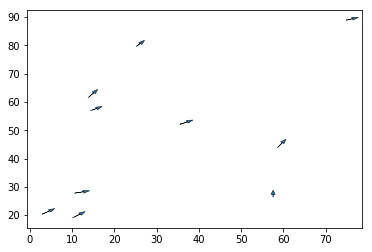

In [39]:
plt.plot(coordinates_of_all_points[:,0], coordinates_of_all_points[:,1], ",")
for i in range(N):
    plt.arrow(coordinates_of_all_points[i,0], coordinates_of_all_points[i,1], velocities_of_all_points[i,0], velocities_of_all_points[i,1], shape='full', lw=0.5, length_includes_head=True, head_width=1)
plt.show()